## Import All The Dependencies

In [1]:
import os
import deeplake
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

ROOT_DIR = os.path.dirname(os.path.abspath(''))
print(ROOT_DIR)

c:\jason\new magang\DUCK-Net\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\jason\new magang\DUCK-Net


## Load Deeplake Dataset

To load a dataset from Deeplake, you need to obtain the Activeloop token and use it to authenticate. Below is a sample code snippet to load training, validation, and test datasets from Deeplake.

In [2]:
# Get the Activeloop token
activeloop_token = os.getenv('ACTIVELOOP_TOKEN')
os.environ['ACTIVELOOP_TOKEN'] = activeloop_token

ds_train = deeplake.load('hub://jasonadrianzoom/colonoscopytrain')
ds_val = deeplake.load('hub://jasonadrianzoom/colonoscopyval')
ds_test = deeplake.load('hub://jasonadrianzoom/colonoscopytest')

\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopytrain



\

hub://jasonadrianzoom/colonoscopytrain loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopyval



\

hub://jasonadrianzoom/colonoscopyval loaded successfully.



\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/jasonadrianzoom/colonoscopytest



/

hub://jasonadrianzoom/colonoscopytest loaded successfully.



# Displaying Image and Segmentation Mask Side by Side

This script displays an image and its corresponding segmentation mask side by side using `matplotlib`.

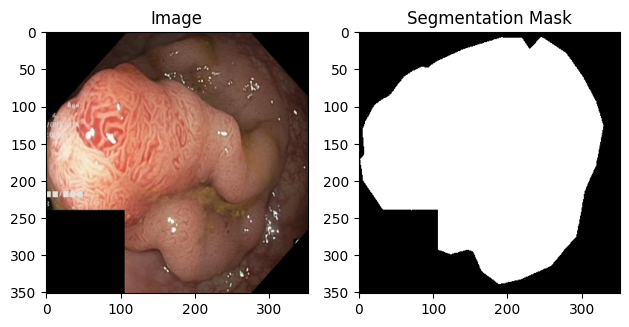

In [3]:
image = ds_train.images[21].numpy()
segmentation = ds_train.masks[21].numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Image')

# Display the segmentation mask
axes[1].imshow(segmentation, cmap='gray')
axes[1].set_title('Segmentation Mask')

# Show the plot
plt.tight_layout()
plt.show()

## Image Augmentation

In [4]:
RGB_MEAN = [0]
RGB_STD = [1]
INPUT_SIZE = (352, 352)

TRAIN_TRANSFORMATION = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
    albu.Normalize(mean=0, std=1),
    ToTensorV2()
])

VAL_TRANSFORMATION = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Normalize(mean=0, std=1),
    ToTensorV2()
])

TEST_TRANSFORMATION = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Normalize(mean=0, std=1),
    ToTensorV2()
])

In [5]:
import glob
from typing import Optional, Tuple

import torch
from torch.utils.data import Dataset
import torchvision

class KvasirDatasetParser(Dataset):
    def __init__(self, transform: Optional[torchvision.transforms.Compose] = None, ds= None):
        self.ds = ds
        self.transform = transform
        self.normalize = albu.Compose([
                            albu.Normalize(mean=0, std=1),
                            ToTensorV2()
                            ])

    def __len__(self) -> int:
        """Get number of images."""
        return len(self.ds)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = self.ds.images[idx].numpy()
        mask = self.ds.masks[idx].numpy()

        # Apply transformations
        if self.transform:
            ug = self.transform(image=image, mask=mask)
            image = ug['image']
            mask = ug['mask']

        # If no transformations, Normalize to [0,1]
        if isinstance(image, np.ndarray):
            ug = self.normalize(image=image, mask=mask)
            image = ug['image']
            mask = ug['mask']

        return image, mask

## Validating Parser

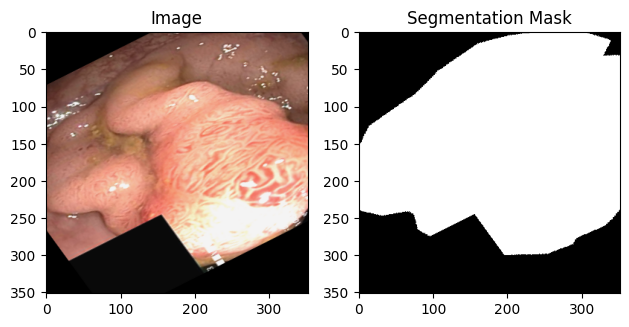

Number of image on the training dataset: 
 800


In [6]:
train_dataset = KvasirDatasetParser(ds=ds_train, transform=TRAIN_TRANSFORMATION)
image, mask = train_dataset[21]

assert image.shape == (3,352,352)
assert mask.shape == (352,352,1)
assert isinstance(image, torch.Tensor)
assert isinstance(mask, torch.Tensor)

# Plot the normalized tensor as an image
# Convert the normalized tensor to a NumPy array and permute
image_viz = image.permute(1, 2, 0).numpy()
mask_viz = mask.squeeze().numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the image
axes[0].imshow(image_viz)
axes[0].set_title('Image')

# Display the segmentation mask
axes[1].imshow(mask_viz, cmap='gray')
axes[1].set_title('Segmentation Mask')

# Show the plot
plt.tight_layout()
plt.show()


print('Number of image on the training dataset: \n', len(train_dataset))

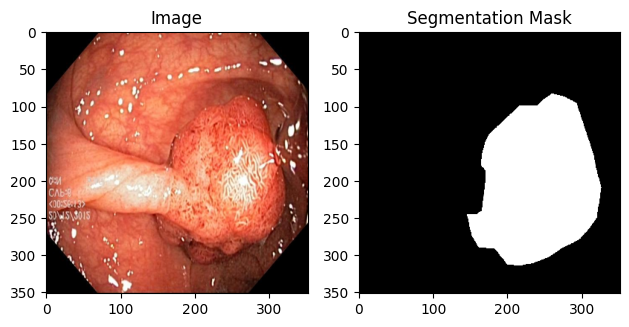

Number of image on the training dataset: 
 100


In [7]:
val_dataset = KvasirDatasetParser(ds=ds_val, transform=VAL_TRANSFORMATION)
image, mask = val_dataset[21]

assert image.shape == (3,352,352)
assert mask.shape == (352,352,1)
assert isinstance(image, torch.Tensor)
assert isinstance(mask, torch.Tensor)

# Plot the normalized tensor as an image
# Convert the normalized tensor to a NumPy array and permute
image_viz = image.permute(1, 2, 0).numpy()
mask_viz = mask.squeeze().numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the image
axes[0].imshow(image_viz)
axes[0].set_title('Image')

# Display the segmentation mask
axes[1].imshow(mask_viz, cmap='gray')
axes[1].set_title('Segmentation Mask')

# Show the plot
plt.tight_layout()
plt.show()


print('Number of image on the training dataset: \n', len(val_dataset))

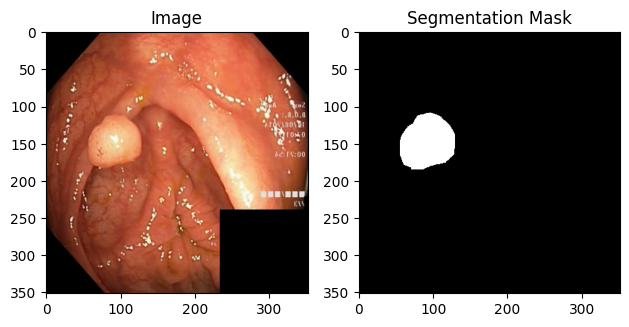

Number of image on the training dataset: 
 100


In [8]:
test_dataset = KvasirDatasetParser(ds=ds_test, transform=TEST_TRANSFORMATION)
image, mask = test_dataset[21]

assert image.shape == (3,352,352)
assert mask.shape == (352,352,1)
assert isinstance(image, torch.Tensor)
assert isinstance(mask, torch.Tensor)

# Plot the normalized tensor as an image
# Convert the normalized tensor to a NumPy array and permute
image_viz = image.permute(1, 2, 0).numpy()
mask_viz = mask.squeeze().numpy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the image
axes[0].imshow(image_viz)
axes[0].set_title('Image')

# Display the segmentation mask
axes[1].imshow(mask_viz, cmap='gray')
axes[1].set_title('Segmentation Mask')

# Show the plot
plt.tight_layout()
plt.show()


print('Number of image on the training dataset: \n', len(test_dataset))

In [9]:
# Cleanup to reduce memory
train_dataset = None
val_dataset = None
test_dataset = None
image, segmentation = None, None